Daniel Hu, Tanish Thaker, Shouro Shuvit, Kiratiya Barrera\
STAT 335\
Scott Bruce\
3 December 2024
<div align="center"><b>
An Analysis of Models for Predicting Outcomes in Multiplayer Online Battle Arenas
</b></div>

**Hypothesis and Outline**

League of Legends (LoL) is a top-down Multiplayer Online Battle Arena(MOBA) that centralizes around teamplay and strategy. Due to its popularity, the game has the largest Esports scene in the world in terms of viewership. As such, many members of the community as well as pro-players wish to understand the leading causes for victory at the highest level of gameplay, i.e, trying to predict which covariates have the highest correlation with a win or a loss, both player-wise, team-wise, and role-wise.

We claim kill-death-assist ratio, creep score (cs) per minute, gold per minute, and total time spent dead provide a high correlation with wins, as well are inversely correlated with losses. Kill-death-assist ratio is important because it states whether a team is alive longer than the other team, creep score per minute and gold per minute states how well a player capitalizes on early game money making to then acquire better gear for late game.

In terms of data analysis,  model selection will be based upon accuracy for win prediction compared to live results, then we used MSE to get a second opinion for the model selection.
Assessing the validity of the hypothesis is as simple as comparing the covariates with the highest accuracy to the covariates we predicted.



**Describing the Data**

The target variable we are looking for is called win, this target variable is looking for if a team/player is winning the match that they play. The predictors are all of the other filtered/relevant covariates in the following table


In [5]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/STAT_335/STAT_335_Final_Project/'

Mounted at /content/drive
/content/drive/MyDrive/STAT_335/STAT_335_Final_Project


In [6]:
import pandas as pd

def clean_data(df):
    # Drop columns: 'gameid', 'datacompleteness' and 50 other columns
    df = df.drop(columns=['gameid', 'datacompleteness', 'url', 'league', 'split', 'year', 'playoffs', 'date', 'game', 'patch', 'participantid', 'side', 'teamid', 'champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'gamelength', 'doublekills', 'triplekills', 'quadrakills', 'pentakills', 'firstbloodassist', 'firstbloodkill', 'firstbloodvictim', 'firstdragon', 'dragons', 'opp_dragons', 'elementaldrakes', 'infernals', 'opp_elementaldrakes', 'mountains', 'clouds', 'oceans', 'chemtechs', 'hextechs', 'dragons (type unknown)', 'elders', 'opp_elders', 'firstherald', 'heralds', 'opp_heralds', 'firstbaron', 'firsttower', 'towers', 'opp_towers', 'firstmidtower', 'firsttothreetowers', 'turretplates', 'opp_turretplates'])
    # Drop rows with missing data in columns: 'playername', 'result'
    df = df.dropna(subset=['playername', 'result'])
    # Drop column: 'gspd'
    df = df.drop(columns=['gspd'])
    # Drop column: 'monsterkillsenemyjungle'
    df = df.drop(columns=['monsterkillsenemyjungle'])
    # Drop column: 'monsterkillsownjungle'
    df = df.drop(columns=['monsterkillsownjungle'])
    # Drop rows with missing data across all columns
    df = df.dropna()
    # Drop column: 'playerid'
    df = df.drop(columns=['playerid'])
    # Export DataFrame to an Excel file
    df.to_excel("output.xlsx", index=False)
    return df

# Loaded variable 'df' from URI: c:\Users\ssjed\OneDrive\Documents\GitHub\Fall2024\STAT 335\Final\2024_LoL_esports_match_data_from_OraclesElixir.xlsx
df = pd.read_excel(r'2024_LoL_esports_match_data_from_OraclesElixir.xlsx')

df_clean = clean_data(df.copy())
df_clean.head()


position playername  teamname  result  kills  deaths  assists  teamkills  \
216      top       Adam  Team BDS       0      3       3        3         10   
217      jng       Sheo  Team BDS       0      2       2        2         10   
218      mid        nuc  Team BDS       0      2       3        1         10   
219      bot        Ice  Team BDS       0      2       2        2         10   
220      sup     Labrov  Team BDS       0      1       4        3         10   

     teamdeaths  firstblood  ...  opp_csat15  golddiffat15  xpdiffat15  \
216          14         1.0  ...       135.0        1690.0      -346.0   
217          14         1.0  ...        95.0        -378.0        74.0   
218          14         0.0  ...       152.0         279.0      -330.0   
219          14         0.0  ...       109.0         213.0      1319.0   
220          14         0.0  ...        23.0         -75.0     -1313.0   

     csdiffat15  killsat15  assistsat15  deathsat15  opp_killsat15  \
216        -1.0        2.0          1.0         1.0            0.0   
217         3.0        1.0          2.0         0.0            2.0   
218       -16.0        1.0          0.0         0.0            0.0   
219        17.0        2.0          1.0         2.0            3.0   
220        -8.0        0.0          3.0         2.0            0.0   

     opp_assistsat15  opp_deathsat15  
216              1.0             2.0  
217              2.0             0.0  
218              1.0             0.0  
219              1.0             2.0  
220              3.0             2.0  

[5 rows x 67 columns]

The original data file had multiple covariates that were not relevant towards determining a win or loss, e.g., match time, match id, etc. These were filtered based upon logical deduction and gameplay experience, allowing for more accurate models. There was no feature engineering.

The data set used was provided by the company Riot Games, who made the game League of Legends, as well as hosts the Esports scene for League. The data was collected from the 2024 Season, which started on January 10th and ended on November 2nd with the World Championships. It includes data from all tier 1 matches from every region hosted by Riot Games in the form of booleans and decimals. We don’t know the exact collection method, but Riot Games has access to all statistics for every match played during the season.


**Model Training, Comparison, and Evaluation**

The data itself was not split initially, however each model had identical test and training data as set by the seed. We then compared and evaluated each model before moving on to the next training method.

In [17]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns


# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

Count         Mean      Std Dev        Min         25%  \
team kpm        4172.0     0.592503     0.193242     0.0759     0.45290   
teamkills       4172.0    18.540748     5.297753     3.0000    15.00000   
teamdeaths      4172.0     9.091802     5.263834     0.0000     5.00000   
assists         4172.0     8.879434     4.454150     0.0000     6.00000   
deaths          4172.0     1.818552     1.591729     0.0000     1.00000   
earned gpm      4172.0   267.013259    79.618896    87.2357   205.64765   
opp_inhibitors  4172.0     0.019415     0.157470     0.0000     0.00000   
inhibitors      4172.0     0.351870     0.576337     0.0000     0.00000   
kills           4172.0     3.703979     2.914403     0.0000     1.00000   
earnedgold      4172.0  8511.633749  2789.826923  2830.0000  6336.75000   

                      50%           75%         Max  Correlation to Wins  
team kpm           0.5746      0.712200      1.4758             0.687156  
teamkills         18.0000     22.000000     37.0000             0.668952  
teamdeaths         8.0000     12.000000     39.0000             0.667032  
assists            8.0000     12.000000     30.0000             0.527882  
deaths             2.0000      3.000000     12.0000             0.491785  
earned gpm       275.8944    325.860825    541.3374             0.410710  
opp_inhibitors     0.0000      0.000000      3.0000             0.365759  
inhibitors         0.0000      1.000000      4.0000             0.362195  
kills              3.0000      5.000000     17.0000             0.359362  
earnedgold      8543.5000  10345.000000  19364.0000             0.342947

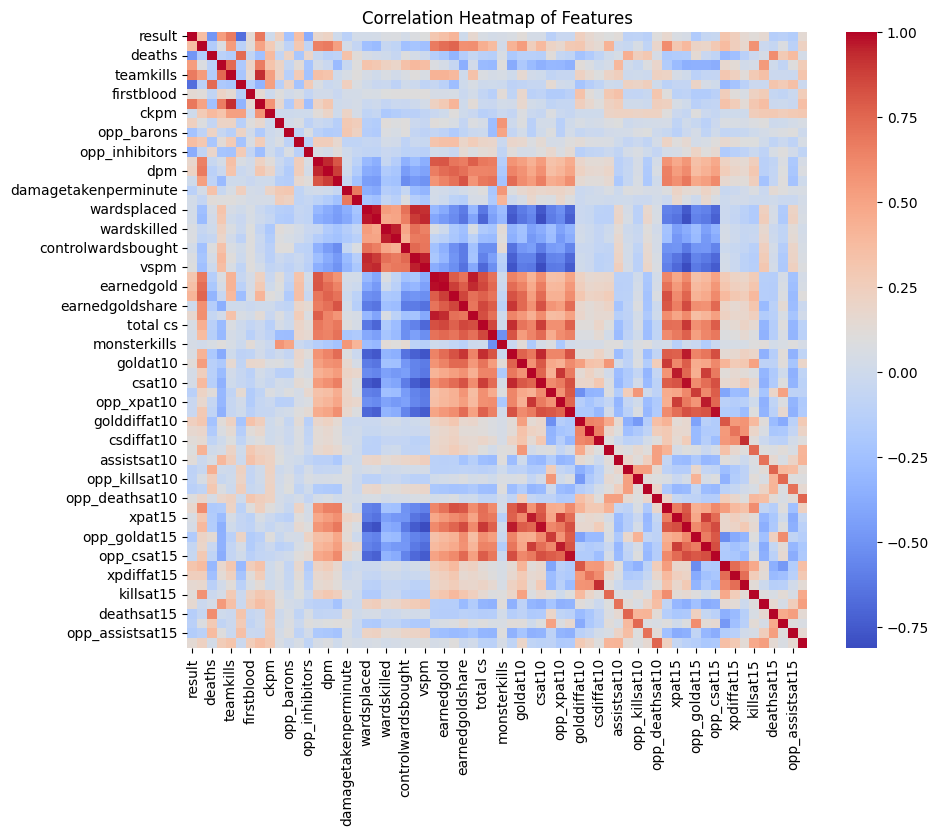

In [18]:
# Select only numeric columns
numeric_df_clean = df_clean.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df_clean.corr()

# Get the absolute values of the correlation matrix
abs_correlation_matrix = correlation_matrix.abs()

# Unstack the matrix and sort by correlation value
sorted_correlations = abs_correlation_matrix.unstack().sort_values(ascending=False)

# Drop the duplicate pairs (correlation of a variable with itself)
sorted_correlations = sorted_correlations[sorted_correlations != 1]

# Display the sorted correlations
sorted_correlations

# Calculate the correlation of 'result' with all other columns
result_correlations = abs_correlation_matrix['result']

# Sort the correlations by absolute value in descending order
sorted_result_correlations = result_correlations.sort_values(ascending=False)

# Display the sorted correlations
sorted_result_correlations

# Get the top 10 features based on sorted_correlations, removing results/first one
top_features = sorted_result_correlations.index[1:11]

# Filter the DataFrame for wins (result = 1)
df_wins = df_clean_teams[df_clean_teams['result'] == 1]

# Calculate descriptive statistics for the top features in the wins dataset
descriptive_stats_wins = df_wins[top_features].describe()

# Transpose for better readability
descriptive_stats_wins_transposed = descriptive_stats_wins.transpose()

# Rename columns for clarity
descriptive_stats_wins_transposed.columns = ['Count', 'Mean', 'Std Dev', 'Min', '25%', '50%', '75%', 'Max']

# Add the correlation to wins column
descriptive_stats_wins_transposed['Correlation to Wins'] = sorted_result_correlations[top_features].values

# Display the descriptive statistics for wins (top 10 most correlated features)
from IPython.display import display

# Display the descriptive statistics
display(descriptive_stats_wins_transposed)

# Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Features")
plt.show()

In [ ]:
# Select only numeric columns
numeric_df_clean = df_clean.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df_clean.corr()

# Get the absolute values of the correlation matrix
abs_correlation_matrix = correlation_matrix.abs()

# Unstack the matrix and sort by correlation value
sorted_correlations = abs_correlation_matrix.unstack().sort_values(ascending=False)

# Drop the duplicate pairs (correlation of a variable with itself)
sorted_correlations = sorted_correlations[sorted_correlations != 1]

# Display the sorted correlations
sorted_correlations

csat15           csat10             0.983146
csat10           csat15             0.983146
opp_csat10       opp_csat15         0.983115
opp_csat15       opp_csat10         0.983115
totalgold        earnedgold         0.982773
                                      ...   
earnedgoldshare  team kpm           0.000105
result           earnedgoldshare    0.000041
earnedgoldshare  result             0.000041
ckpm             result             0.000017
result           ckpm               0.000017
Length: 4032, dtype: float64

In [10]:
# Create datasets based on position
positions = ['top', 'jng', 'mid', 'bot', 'sup']
datasets = {}

for position in positions:
    datasets[position] = df_clean[df_clean['position'] == position]

# Display the first few rows of each dataset
for position, dataset in datasets.items():
    print(f"Dataset for position: {position}")
    print(dataset.head())
    print("\n")

Dataset for position: top
    position   playername      teamname  result  kills  deaths  assists  \
216      top         Adam      Team BDS       0      3       3        3   
221      top  BrokenBlade    G2 Esports       1      4       3        2   
228      top     Szygenda         Rogue       0      0       3        2   
233      top   Irrelevant     SK Gaming       1      6       1        6   
240      top    Cabochard  Karmine Corp       0      0       4        4   

     teamkills  teamdeaths  firstblood  ...  opp_csat15  golddiffat15  \
216         10          14         1.0  ...       135.0        1690.0   
221         14          10         0.0  ...       134.0       -1690.0   
228          4          16         0.0  ...       133.0        -136.0   
233         16           4         0.0  ...       118.0         136.0   
240          9          20         0.0  ...       142.0        -175.0   

     xpdiffat15  csdiffat15  killsat15  assistsat15  deathsat15  \
216      -346.0  

RUN ON FIRST TIME ONLY

In [11]:
df_clean_teams = df_clean.sort_values(['teamname'], ascending=[False])
df_clean_teams.head()
df_clean_teams.to_excel("teams.xlsx", index=False)


In [12]:
import pandas as pd
import os

# Create an Excel file for each role
for position, dataset in datasets.items():
     filename = f"{position}_dataset.xlsx"
     dataset.to_excel(filename, index=False)
     print(f"Created {filename}")

Created top_dataset.xlsx
Created jng_dataset.xlsx
Created mid_dataset.xlsx
Created bot_dataset.xlsx
Created sup_dataset.xlsx


RUN ON FIRST TIME ONLY

In [13]:
# Create the 'roles' directory if it doesn't exist
if not os.path.exists('roles'):
     os.makedirs('roles')

 # Move the Excel files to the 'roles' directory
for position, dataset in datasets.items():
     filename = f"{position}_dataset.xlsx"
     destination = os.path.join('roles', filename)
     if os.path.exists(destination):
         os.remove(destination)
     os.rename(filename, destination)
     print(f"Moved {filename} to roles/{filename}")

Moved top_dataset.xlsx to roles/top_dataset.xlsx
Moved jng_dataset.xlsx to roles/jng_dataset.xlsx
Moved mid_dataset.xlsx to roles/mid_dataset.xlsx
Moved bot_dataset.xlsx to roles/bot_dataset.xlsx
Moved sup_dataset.xlsx to roles/sup_dataset.xlsx


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define the feature columns and target variable
features = numeric_df_clean.drop(columns=['result'])
target = numeric_df_clean['result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression(max_iter=8334)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.9610077984403119
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       846
           1       0.96      0.96      0.96       821

    accuracy                           0.96      1667
   macro avg       0.96      0.96      0.96      1667
weighted avg       0.96      0.96      0.96      1667



c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
import numpy as np

import statsmodels.api as sm

# Add a constant to the features
X_train_const = sm.add_constant(X_train)

# Fit the initial model with all features
model = sm.Logit(y_train, X_train_const).fit()

# Perform backward selection
def backward_selection(data, target, significance_level=0.05):
    features = data.columns.tolist()
    while len(features) > 0:
        X = sm.add_constant(data[features])
        model = sm.Logit(target, X).fit(disp=0)
        p_values = model.pvalues[1:]  # Exclude the intercept
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features

# Run backward selection
selected_features = backward_selection(X_train, y_train)

# Fit the final model with selected features
X_train_selected = sm.add_constant(X_train[selected_features])
final_model = sm.Logit(y_train, X_train_selected).fit()

# Evaluate the final model
X_test_selected = sm.add_constant(X_test[selected_features])
y_pred = final_model.predict(X_test_selected)
y_pred_class = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_class)
report = classification_report(y_test, y_pred_class)

print(f'Selected Features: {selected_features}')
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

         Current function value: 0.053815
         Iterations: 35


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Optimization terminated successfully.
         Current function value: 0.056230
         Iterations 12
Selected Features: ['assists', 'teamkills', 'teamdeaths', 'team kpm', 'ckpm', 'inhibitors', 'opp_inhibitors', 'wardsplaced', 'visionscore', 'earned gpm', 'earnedgoldshare', 'goldspent', 'minionkills', 'cspm', 'csat15', 'opp_goldat15', 'opp_csat15', 'killsat15', 'assistsat15', 'opp_killsat15', 'opp_assistsat15']
Accuracy: 0.976004799040192
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       846
           1       0.98      0.98      0.98       821

    accuracy                           0.98      1667
   macro avg       0.98      0.98      0.98      1667
weighted avg       0.98      0.98      0.98      1667



In [ ]:
# Load the teams dataset
df_teams = pd.read_excel("teams.xlsx")

# Select only numeric columns
numeric_df_teams = df_teams.select_dtypes(include=['number'])

# Define the feature columns and target variable
features_teams = numeric_df_teams.drop(columns=['result'])
target_teams = numeric_df_teams['result']

# Split the data into training and testing sets
X_train_teams, X_test_teams, y_train_teams, y_test_teams = train_test_split(features_teams, target_teams, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model_teams = LogisticRegression(max_iter=8334)
model_teams.fit(X_train_teams, y_train_teams)

# Make predictions on the test set
y_pred_teams = model_teams.predict(X_test_teams)

# Evaluate the model
accuracy_teams = accuracy_score(y_test_teams, y_pred_teams)
report_teams = classification_report(y_test_teams, y_pred_teams)

print(f'Accuracy: {accuracy_teams}')
print('Classification Report:')
print(report_teams)

Accuracy: 0.9598080383923215
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       813
           1       0.96      0.96      0.96       854

    accuracy                           0.96      1667
   macro avg       0.96      0.96      0.96      1667
weighted avg       0.96      0.96      0.96      1667



c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Run backward selection for the teams dataset
selected_features_teams = backward_selection(features_teams, target_teams)

# Fit the final model with selected features
X_train_teams_selected = sm.add_constant(X_train_teams[selected_features_teams])
final_model_teams = sm.Logit(y_train_teams, X_train_teams_selected).fit()

# Evaluate the final model
X_test_teams_selected = sm.add_constant(X_test_teams[selected_features_teams])
y_pred_teams_selected = final_model_teams.predict(X_test_teams_selected)
y_pred_teams_class = (y_pred_teams_selected > 0.5).astype(int)

accuracy_teams_selected = accuracy_score(y_test_teams, y_pred_teams_class)
report_teams_selected = classification_report(y_test_teams, y_pred_teams_class)

print(f'Selected Features: {selected_features_teams}')
print(f'Accuracy: {accuracy_teams_selected}')
print('Classification Report:')
print(report_teams_selected)

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Optimization terminated successfully.
         Current function value: 0.056164
         Iterations 12
Selected Features: ['assists', 'teamkills', 'teamdeaths', 'team kpm', 'ckpm', 'barons', 'opp_barons', 'inhibitors', 'opp_inhibitors', 'wardsplaced', 'visionscore', 'earned gpm', 'earnedgoldshare', 'goldspent', 'total cs', 'cspm', 'csat15', 'opp_goldat15', 'opp_csat15', 'killsat15', 'assistsat15', 'opp_killsat15', 'opp_assistsat15']
Accuracy: 0.976004799040192
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       813
           1       0.98      0.98      0.98       854

    accuracy                           0.98      1667
   macro avg       0.98      0.98      0.98      1667
weighted avg       0.98      0.98      0.98      1667



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Iterate through each dataset in the roles folder
for position, dataset in datasets.items():
    # Select only numeric columns
    numeric_dataset = dataset.select_dtypes(include=['number'])

    # Define the feature columns and target variable
    features = numeric_dataset.drop(columns=['result'])
    target = numeric_dataset['result']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Create and train the logistic regression model
    model = LogisticRegression(max_iter=8334)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f'Position: {position}')
    print(f'Accuracy: {accuracy}')
    print('Classification Report:')
    print(report)
    print('\n')

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Position: top
Accuracy: 0.972972972972973
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       165
           1       0.96      0.98      0.97       168

    accuracy                           0.97       333
   macro avg       0.97      0.97      0.97       333
weighted avg       0.97      0.97      0.97       333





c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Position: jng
Accuracy: 0.9670658682634731
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       169
           1       0.97      0.96      0.97       165

    accuracy                           0.97       334
   macro avg       0.97      0.97      0.97       334
weighted avg       0.97      0.97      0.97       334





c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Position: mid
Accuracy: 0.9640718562874252
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       169
           1       0.98      0.95      0.96       165

    accuracy                           0.96       334
   macro avg       0.96      0.96      0.96       334
weighted avg       0.96      0.96      0.96       334





c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Position: bot
Accuracy: 0.9579579579579579
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       181
           1       0.96      0.95      0.95       152

    accuracy                           0.96       333
   macro avg       0.96      0.96      0.96       333
weighted avg       0.96      0.96      0.96       333



Position: sup
Accuracy: 0.9520958083832335
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       164
           1       0.94      0.96      0.95       170

    accuracy                           0.95       334
   macro avg       0.95      0.95      0.95       334
weighted avg       0.95      0.95      0.95       334





c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Dictionary to store the best models and their summaries for each role
best_models = {}

# Iterate through each dataset in the roles folder
for position, dataset in datasets.items():
    # Select only numeric columns
    numeric_dataset = dataset.select_dtypes(include=['number'])

    # Define the feature columns and target variable
    features = numeric_dataset.drop(columns=['result'])
    target = numeric_dataset['result']

    # Run backward selection
    selected_features = backward_selection(features, target)

    # Fit the final model with selected features
    X_train_selected = sm.add_constant(features[selected_features])
    final_model = sm.Logit(target, X_train_selected).fit()

    # Save the selected features and model summary
    best_models[position] = {
        'selected_features': selected_features,
        'model_summary': final_model.summary()
    }

    # Display the selected features and model summary
    print(f'Position: {position}')
    print(f'Selected Features: {selected_features}')
    print(final_model.summary())
    print('\n')

# Display the best models and their summaries for each role
for position, model_info in best_models.items():
    print(f'Position: {position}')
    print(f'Selected Features: {model_info["selected_features"]}')
    print(model_info['model_summary'])
    print('\n')

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Optimization terminated successfully.
         Current function value: 0.049551
         Iterations 12
Position: top
Selected Features: ['assists', 'teamdeaths', 'team kpm', 'ckpm', 'barons', 'opp_inhibitors', 'damagetochampions', 'dpm', 'damageshare', 'earned gpm', 'earnedgoldshare', 'goldspent', 'opp_xpat10', 'opp_xpat15']
                           Logit Regression Results                           
Dep. Variable:                 result   No. Observations:                 1664
Model:                          Logit   Df Residuals:                     1649
Method:                           MLE   Df Model:                           14
Date:                Mon, 02 Dec 2024   Pseudo R-squ.:                  0.9285
Time:                        13:58:58   Log-Likelihood:                -82.452
converged:                       True   LL-Null:                       -1153.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err  

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Optimization terminated successfully.
         Current function value: 0.037739
         Iterations 12
Position: jng
Selected Features: ['assists', 'team kpm', 'ckpm', 'inhibitors', 'opp_inhibitors', 'damagemitigatedperminute', 'wardsplaced', 'visionscore', 'earnedgold', 'earned gpm', 'earnedgoldshare', 'goldspent', 'csdiffat10', 'opp_killsat10', 'opp_xpat15', 'opp_csat15', 'killsat15', 'assistsat15', 'opp_killsat15', 'opp_assistsat15']
                           Logit Regression Results                           
Dep. Variable:                 result   No. Observations:                 1668
Model:                          Logit   Df Residuals:                     1647
Method:                           MLE   Df Model:                           20
Date:                Mon, 02 Dec 2024   Pseudo R-squ.:                  0.9456
Time:                        13:59:01   Log-Likelihood:                -62.949
converged:                       True   LL-Null:                       -1156.2
Covari

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Optimization terminated successfully.
         Current function value: 0.039345
         Iterations 13
Position: mid
Selected Features: ['assists', 'teamdeaths', 'team kpm', 'ckpm', 'opp_barons', 'inhibitors', 'opp_inhibitors', 'totalgold', 'earnedgold', 'earned gpm', 'earnedgoldshare', 'goldspent', 'total cs', 'monsterkills', 'cspm', 'csdiffat10', 'golddiffat15', 'assistsat15', 'opp_killsat15', 'opp_assistsat15']
                           Logit Regression Results                           
Dep. Variable:                 result   No. Observations:                 1668
Model:                          Logit   Df Residuals:                     1647
Method:                           MLE   Df Model:                           20
Date:                Mon, 02 Dec 2024   Pseudo R-squ.:                  0.9432
Time:                        13:59:04   Log-Likelihood:                -65.627
converged:                       True   LL-Null:                       -1156.2
Covariance Type:            n

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Optimization terminated successfully.
         Current function value: 0.041358
         Iterations 13
Position: bot
Selected Features: ['teamkills', 'teamdeaths', 'team kpm', 'ckpm', 'opp_inhibitors', 'damagetochampions', 'wardsplaced', 'wardskilled', 'wcpm', 'earned gpm', 'earnedgoldshare', 'goldspent', 'xpat10', 'opp_goldat10', 'opp_xpat10', 'golddiffat10', 'csdiffat10', 'killsat10', 'assistsat10', 'opp_killsat10', 'opp_assistsat10', 'opp_goldat15', 'golddiffat15', 'xpdiffat15', 'csdiffat15']
                           Logit Regression Results                           
Dep. Variable:                 result   No. Observations:                 1664
Model:                          Logit   Df Residuals:                     1638
Method:                           MLE   Df Model:                           25
Date:                Mon, 02 Dec 2024   Pseudo R-squ.:                  0.9403
Time:                        13:59:08   Log-Likelihood:                -68.819
converged:               

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Optimization terminated successfully.
         Current function value: 0.034819
         Iterations 14
Position: sup
Selected Features: ['teamdeaths', 'team kpm', 'ckpm', 'damageshare', 'damagetakenperminute', 'controlwardsbought', 'earned gpm', 'earnedgoldshare', 'goldspent', 'total cs', 'goldat10', 'opp_csat10', 'xpdiffat10', 'deathsat10', 'opp_killsat10', 'opp_assistsat10', 'opp_deathsat10', 'opp_xpat15', 'golddiffat15', 'csdiffat15', 'killsat15', 'assistsat15', 'opp_killsat15', 'opp_assistsat15', 'opp_deathsat15']
                           Logit Regression Results                           
Dep. Variable:                 result   No. Observations:                 1670
Model:                          Logit   Df Residuals:                     1644
Method:                           MLE   Df Model:                           25
Date:                Mon, 02 Dec 2024   Pseudo R-squ.:                  0.9498
Time:                        13:59:10   Log-Likelihood:                -58.148
co

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the feature columns and target variable
features = numeric_df_clean.drop(columns=['result'])
target = numeric_df_clean['result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
log_accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {log_accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.9556088782243551
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       846
           1       0.95      0.96      0.96       821

    accuracy                           0.96      1667
   macro avg       0.96      0.96      0.96      1667
weighted avg       0.96      0.96      0.96      1667



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Function to perform backward selection
def backward_selection_rf(X_train, y_train, X_test, y_test, significance_level=0.05):
    features = X_train.columns.tolist()
    best_accuracy = 0
    best_features = features.copy()

    while len(features) > 0:
        # Train the Random Forest model
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(X_train[features], y_train)

        # Make predictions on the test set
        y_pred = rf_model.predict(X_test[features])

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = features.copy()

        # Get feature importances
        importances = rf_model.feature_importances_

        # Find the least important feature
        least_important_feature = features[np.argmin(importances)]

        # Remove the least important feature
        features.remove(least_important_feature)

    return best_features, best_accuracy

# Run backward selection
selected_features_rf, best_accuracy_rf = backward_selection_rf(X_train, y_train, X_test, y_test)

# Fit the final Random Forest model with selected features
rf_model_final = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_final.fit(X_train[selected_features_rf], y_train)

# Make predictions on the test set
y_pred_rf_final = rf_model_final.predict(X_test[selected_features_rf])

# Evaluate the final model
accuracy_rf_final = accuracy_score(y_test, y_pred_rf_final)
report_rf_final = classification_report(y_test, y_pred_rf_final)

print(f'Selected Features: {selected_features_rf}')
print(f'Best Accuracy: {best_accuracy_rf}')
print('Final Model Accuracy:', accuracy_rf_final)
print('Classification Report:')
print(report_rf_final)

Selected Features: ['teamkills', 'teamdeaths', 'team kpm', 'ckpm']
Best Accuracy: 0.9868026394721056
Final Model Accuracy: 0.9868026394721056
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       846
           1       0.98      0.99      0.99       821

    accuracy                           0.99      1667
   macro avg       0.99      0.99      0.99      1667
weighted avg       0.99      0.99      0.99      1667



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the feature columns and target variable
features_teams = numeric_df_teams.drop(columns=['result'])
target_teams = numeric_df_teams['result']

# Split the data into training and testing sets
X_train_teams, X_test_teams, y_train_teams, y_test_teams = train_test_split(features_teams, target_teams, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model_teams = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_teams.fit(X_train_teams, y_train_teams)

# Make predictions on the test set
y_pred_teams = rf_model_teams.predict(X_test_teams)

# Evaluate the model
accuracy_teams = accuracy_score(y_test_teams, y_pred_teams)
report_teams = classification_report(y_test_teams, y_pred_teams)

print(f'Accuracy: {accuracy_teams}')
print('Classification Report:')
print(report_teams)

Accuracy: 0.9436112777444511
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       813
           1       0.95      0.94      0.94       854

    accuracy                           0.94      1667
   macro avg       0.94      0.94      0.94      1667
weighted avg       0.94      0.94      0.94      1667



In [ ]:
# Run backward selection for the teams dataset using Random Forest
selected_features_rf_teams, best_accuracy_rf_teams = backward_selection_rf(X_train_teams, y_train_teams, X_test_teams, y_test_teams)

# Fit the final Random Forest model with selected features
rf_model_final_teams = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_final_teams.fit(X_train_teams[selected_features_rf_teams], y_train_teams)

# Make predictions on the test set
y_pred_rf_final_teams = rf_model_final_teams.predict(X_test_teams[selected_features_rf_teams])

# Evaluate the final model
accuracy_rf_final_teams = accuracy_score(y_test_teams, y_pred_rf_final_teams)
report_rf_final_teams = classification_report(y_test_teams, y_pred_rf_final_teams)

print(f'Selected Features: {selected_features_rf_teams}')
print(f'Best Accuracy: {best_accuracy_rf_teams}')
print('Final Model Accuracy:', accuracy_rf_final_teams)
print('Classification Report:')
print(report_rf_final_teams)

Selected Features: ['teamkills', 'teamdeaths', 'team kpm']
Best Accuracy: 0.9868026394721056
Final Model Accuracy: 0.9868026394721056
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       813
           1       1.00      0.98      0.99       854

    accuracy                           0.99      1667
   macro avg       0.99      0.99      0.99      1667
weighted avg       0.99      0.99      0.99      1667



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Iterate through each dataset in the roles folder
for position, dataset in datasets.items():
    # Select only numeric columns
    numeric_dataset = dataset.select_dtypes(include=['number'])

    # Define the feature columns and target variable
    features = numeric_dataset.drop(columns=['result'])
    target = numeric_dataset['result']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Create and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f'Position: {position}')
    print(f'Accuracy: {accuracy}')
    print('Classification Report:')
    print(report)
    print('\n')

Position: top
Accuracy: 0.9579579579579579
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       165
           1       0.95      0.96      0.96       168

    accuracy                           0.96       333
   macro avg       0.96      0.96      0.96       333
weighted avg       0.96      0.96      0.96       333



Position: jng
Accuracy: 0.9431137724550899
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       169
           1       0.94      0.95      0.94       165

    accuracy                           0.94       334
   macro avg       0.94      0.94      0.94       334
weighted avg       0.94      0.94      0.94       334



Position: mid
Accuracy: 0.9640718562874252
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       169
           1       0.97      0.96  

In [ ]:
# Dictionary to store the best models and their accuracies for each role
best_models_rf = {}

# Iterate through each dataset in the roles folder
for position, dataset in datasets.items():
    # Select only numeric columns
    numeric_dataset = dataset.select_dtypes(include=['number'])

    # Define the feature columns and target variable
    features = numeric_dataset.drop(columns=['result'])
    target = numeric_dataset['result']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Run backward selection
    selected_features_rf, best_accuracy_rf = backward_selection_rf(X_train, y_train, X_test, y_test)

    # Fit the final Random Forest model with selected features
    rf_model_final = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model_final.fit(X_train[selected_features_rf], y_train)

    # Make predictions on the test set
    y_pred_rf_final = rf_model_final.predict(X_test[selected_features_rf])

    # Evaluate the final model
    accuracy_rf_final = accuracy_score(y_test, y_pred_rf_final)
    report_rf_final = classification_report(y_test, y_pred_rf_final)

    # Save the best model and its accuracy
    best_models_rf[position] = {
        'selected_features': selected_features_rf,
        'best_accuracy': best_accuracy_rf,
        'final_model_accuracy': accuracy_rf_final,
        'classification_report': report_rf_final
    }

    print(f'Position: {position}')
    print(f'Selected Features: {selected_features_rf}')
    print(f'Best Accuracy: {best_accuracy_rf}')
    print('Final Model Accuracy:', accuracy_rf_final)
    print('Classification Report:')
    print(report_rf_final)
    print('\n')

# Display the best models and their accuracies for each role
for position, model_info in best_models_rf.items():
    print(f'Position: {position}')
    print(f'Selected Features: {model_info["selected_features"]}')
    print(f'Best Accuracy: {model_info["best_accuracy"]}')
    print(f'Final Model Accuracy: {model_info["final_model_accuracy"]}')
    print('Classification Report:')
    print(model_info['classification_report'])
    print('\n')

Position: top
Selected Features: ['kills', 'deaths', 'assists', 'teamkills', 'teamdeaths', 'team kpm', 'ckpm', 'inhibitors', 'opp_inhibitors', 'damagetochampions', 'dpm', 'damageshare', 'damagetakenperminute', 'damagemitigatedperminute', 'wardsplaced', 'wpm', 'wardskilled', 'wcpm', 'controlwardsbought', 'visionscore', 'vspm', 'totalgold', 'earnedgold', 'earned gpm', 'earnedgoldshare', 'goldspent', 'total cs', 'minionkills', 'monsterkills', 'cspm', 'goldat10', 'xpat10', 'csat10', 'opp_goldat10', 'opp_xpat10', 'opp_csat10', 'golddiffat10', 'xpdiffat10', 'csdiffat10', 'deathsat10', 'goldat15', 'xpat15', 'csat15', 'opp_goldat15', 'opp_xpat15', 'opp_csat15', 'golddiffat15', 'xpdiffat15', 'csdiffat15', 'killsat15', 'assistsat15', 'deathsat15', 'opp_killsat15', 'opp_assistsat15', 'opp_deathsat15']
Best Accuracy: 0.9669669669669669
Final Model Accuracy: 0.9669669669669669
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97  

In [ ]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

# Define the feature columns and target variable
features = numeric_df_clean.drop(columns=['result'])
target = numeric_df_clean['result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create and train the LASSO regression model
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate the LASSO model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f'LASSO Regression Mean Squared Error: {mse_lasso}')

# Create and train the Ridge regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate the Ridge model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f'Ridge Regression Mean Squared Error: {mse_ridge}')


LASSO Regression Mean Squared Error: 0.0559528521044236
Ridge Regression Mean Squared Error: 0.045923088501415694


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.498e+00, tolerance: 1.667e-01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

# Define the feature columns and target variable
features_teams = numeric_df_teams.drop(columns=['result'])
target_teams = numeric_df_teams['result']

# Split the data into training and testing sets
X_train_teams, X_test_teams, y_train_teams, y_test_teams = train_test_split(features_teams, target_teams, test_size=0.2, random_state=42)

# Create and train the LASSO regression model
lasso_model_teams = Lasso(alpha=0.1)
lasso_model_teams.fit(X_train_teams, y_train_teams)

# Make predictions on the test set
y_pred_lasso_teams = lasso_model_teams.predict(X_test_teams)

# Evaluate the LASSO model
mse_lasso_teams = mean_squared_error(y_test_teams, y_pred_lasso_teams)
print(f'LASSO Regression Mean Squared Error for Teams: {mse_lasso_teams}')

# Create and train the Ridge regression model
ridge_model_teams = Ridge(alpha=1.0)
ridge_model_teams.fit(X_train_teams, y_train_teams)

# Make predictions on the test set
y_pred_ridge_teams = ridge_model_teams.predict(X_test_teams)

# Evaluate the Ridge model
mse_ridge_teams = mean_squared_error(y_test_teams, y_pred_ridge_teams)
print(f'Ridge Regression Mean Squared Error for Teams: {mse_ridge_teams}')

LASSO Regression Mean Squared Error for Teams: 0.05668515555171162
Ridge Regression Mean Squared Error for Teams: 0.045121173482898735


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.625e-01, tolerance: 1.667e-01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error


# Iterate through each dataset in the roles folder
for position, dataset in datasets.items():
    # Select only numeric columns
    numeric_dataset = dataset.select_dtypes(include=['number'])

    # Define the feature columns and target variable
    features = numeric_dataset.drop(columns=['result'])
    target = numeric_dataset['result']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Create and train the LASSO regression model
    lasso_model = Lasso(alpha=0.1)
    lasso_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_lasso = lasso_model.predict(X_test)

    # Evaluate the LASSO model
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)

    # Create and train the Ridge regression model
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_ridge = ridge_model.predict(X_test)

    # Evaluate the Ridge model
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)

    print(f'Position: {position}')
    print(f'LASSO Regression Mean Squared Error: {mse_lasso}')
    print(f'Ridge Regression Mean Squared Error: {mse_ridge}')
    print('\n')
    # Save the models and their mean squared errors
    best_models[position] = {
        'lasso_model': lasso_model,
        'ridge_model': ridge_model,
        'mse_lasso': mse_lasso,
        'mse_ridge': mse_ridge
    }

Position: top
LASSO Regression Mean Squared Error: 0.056364698955860645
Ridge Regression Mean Squared Error: 0.04939057384366985


Position: jng
LASSO Regression Mean Squared Error: 0.05612320836752045
Ridge Regression Mean Squared Error: 0.04641196106832661


Position: mid
LASSO Regression Mean Squared Error: 0.0466057672341344
Ridge Regression Mean Squared Error: 0.038064260343096394


Position: bot
LASSO Regression Mean Squared Error: 0.05406915387081739
Ridge Regression Mean Squared Error: 0.043185213995790964


Position: sup
LASSO Regression Mean Squared Error: 0.052776729243536984
Ridge Regression Mean Squared Error: 0.04148347727337864




c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.718e+00, tolerance: 3.327e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e+01, tolerance: 3.335e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the feature columns and target variable
features = numeric_df_clean.drop(columns=['result'])
target = numeric_df_clean['result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)

print(f'Accuracy: {accuracy_knn}')
print('Classification Report:')
print(report_knn)

Accuracy: 0.8014397120575885
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       846
           1       0.80      0.79      0.80       821

    accuracy                           0.80      1667
   macro avg       0.80      0.80      0.80      1667
weighted avg       0.80      0.80      0.80      1667



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Function to perform backward selection
def backward_selection_knn(X_train, y_train, X_test, y_test, significance_level=0.05):
    features = X_train.columns.tolist()
    best_accuracy = 0
    best_features = features.copy()

    while len(features) > 0:
        # Train the KNN model
        knn_model = KNeighborsClassifier(n_neighbors=5)
        knn_model.fit(X_train[features], y_train)

        # Make predictions on the test set
        y_pred = knn_model.predict(X_test[features])

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = features.copy()

        # Calculate feature importances (using permutation importance)
        importances = []
        for feature in features:
            X_test_permuted = X_test.copy()
            X_test_permuted[feature] = np.random.permutation(X_test[feature])
            y_pred_permuted = knn_model.predict(X_test_permuted[features])
            permuted_accuracy = accuracy_score(y_test, y_pred_permuted)
            importances.append(best_accuracy - permuted_accuracy)

        # Find the least important feature
        least_important_feature = features[np.argmin(importances)]

        # Remove the least important feature
        features.remove(least_important_feature)

    return best_features, best_accuracy

# Run backward selection
selected_features_knn, best_accuracy_knn = backward_selection_knn(X_train, y_train, X_test, y_test)

# Fit the final KNN model with selected features
knn_model_final = KNeighborsClassifier(n_neighbors=5)
knn_model_final.fit(X_train[selected_features_knn], y_train)

# Make predictions on the test set
y_pred_knn_final = knn_model_final.predict(X_test[selected_features_knn])

# Evaluate the final model
accuracy_knn_final = accuracy_score(y_test, y_pred_knn_final)
report_knn_final = classification_report(y_test, y_pred_knn_final)

print(f'Selected Features: {selected_features_knn}')
print(f'Best Accuracy: {best_accuracy_knn}')
print('Final Model Accuracy:', accuracy_knn_final)
print('Classification Report:')
print(report_knn_final)

Selected Features: ['totalgold', 'earnedgold', 'goldspent', 'opp_xpat15']
Best Accuracy: 0.8314337132573485
Final Model Accuracy: 0.8314337132573485
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       846
           1       0.83      0.82      0.83       821

    accuracy                           0.83      1667
   macro avg       0.83      0.83      0.83      1667
weighted avg       0.83      0.83      0.83      1667



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the feature columns and target variable
features_teams = numeric_df_teams.drop(columns=['result'])
target_teams = numeric_df_teams['result']

# Split the data into training and testing sets
X_train_teams, X_test_teams, y_train_teams, y_test_teams = train_test_split(features_teams, target_teams, test_size=0.2, random_state=42)

# Create and train the KNN model
knn_model_teams = KNeighborsClassifier(n_neighbors=5)
knn_model_teams.fit(X_train_teams, y_train_teams)

# Make predictions on the test set
y_pred_teams_knn = knn_model_teams.predict(X_test_teams)

# Evaluate the model
accuracy_teams_knn = accuracy_score(y_test_teams, y_pred_teams_knn)
report_teams_knn = classification_report(y_test_teams, y_pred_teams_knn)

print(f'Accuracy: {accuracy_teams_knn}')
print('Classification Report:')
print(report_teams_knn)

Accuracy: 0.7930413917216557
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       813
           1       0.80      0.79      0.80       854

    accuracy                           0.79      1667
   macro avg       0.79      0.79      0.79      1667
weighted avg       0.79      0.79      0.79      1667



In [ ]:
# Run backward selection for the teams dataset using KNN
selected_features_knn_teams, best_accuracy_knn_teams = backward_selection_knn(X_train_teams, y_train_teams, X_test_teams, y_test_teams)

# Fit the final KNN model with selected features
knn_model_final_teams = KNeighborsClassifier(n_neighbors=5)
knn_model_final_teams.fit(X_train_teams[selected_features_knn_teams], y_train_teams)

# Make predictions on the test set
y_pred_knn_final_teams = knn_model_final_teams.predict(X_test_teams[selected_features_knn_teams])

# Evaluate the final model
accuracy_knn_final_teams = accuracy_score(y_test_teams, y_pred_knn_final_teams)
report_knn_final_teams = classification_report(y_test_teams, y_pred_knn_final_teams)

print(f'Selected Features: {selected_features_knn_teams}')
print(f'Best Accuracy: {best_accuracy_knn_teams}')
print('Final Model Accuracy:', accuracy_knn_final_teams)
print('Classification Report:')
print(report_knn_final_teams)

Selected Features: ['totalgold', 'earnedgold', 'goldspent', 'opp_xpat15']
Best Accuracy: 0.8326334733053389
Final Model Accuracy: 0.8326334733053389
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       813
           1       0.86      0.81      0.83       854

    accuracy                           0.83      1667
   macro avg       0.83      0.83      0.83      1667
weighted avg       0.83      0.83      0.83      1667



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Iterate through each dataset in the roles folder
for position, dataset in datasets.items():
    # Select only numeric columns
    numeric_dataset = dataset.select_dtypes(include=['number'])

    # Define the feature columns and target variable
    features = numeric_dataset.drop(columns=['result'])
    target = numeric_dataset['result']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Create and train the KNN model
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = knn_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f'Position: {position}')
    print(f'Accuracy: {accuracy}')
    print('Classification Report:')
    print(report)
    print('\n')

Position: top
Accuracy: 0.7537537537537538
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       165
           1       0.78      0.72      0.75       168

    accuracy                           0.75       333
   macro avg       0.76      0.75      0.75       333
weighted avg       0.76      0.75      0.75       333



Position: jng
Accuracy: 0.7904191616766467
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       169
           1       0.77      0.83      0.80       165

    accuracy                           0.79       334
   macro avg       0.79      0.79      0.79       334
weighted avg       0.79      0.79      0.79       334



Position: mid
Accuracy: 0.7754491017964071
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       169
           1       0.76      0.79  

In [ ]:
# Dictionary to store the best models and their accuracies for each role
best_models_knn = {}

# Iterate through each dataset in the roles folder
for position, dataset in datasets.items():
    # Select only numeric columns
    numeric_dataset = dataset.select_dtypes(include=['number'])

    # Define the feature columns and target variable
    features = numeric_dataset.drop(columns=['result'])
    target = numeric_dataset['result']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Run backward selection
    selected_features_knn, best_accuracy_knn = backward_selection_knn(X_train, y_train, X_test, y_test)

    # Fit the final KNN model with selected features
    knn_model_final = KNeighborsClassifier(n_neighbors=5)
    knn_model_final.fit(X_train[selected_features_knn], y_train)

    # Make predictions on the test set
    y_pred_knn_final = knn_model_final.predict(X_test[selected_features_knn])

    # Evaluate the final model
    accuracy_knn_final = accuracy_score(y_test, y_pred_knn_final)
    report_knn_final = classification_report(y_test, y_pred_knn_final)

    # Save the best model and its accuracy
    best_models_knn[position] = {
        'selected_features': selected_features_knn,
        'best_accuracy': best_accuracy_knn,
        'final_model_accuracy': accuracy_knn_final,
        'classification_report': report_knn_final
    }

    print(f'Position: {position}')
    print(f'Selected Features: {selected_features_knn}')
    print(f'Best Accuracy: {best_accuracy_knn}')
    print('Final Model Accuracy:', accuracy_knn_final)
    print('Classification Report:')
    print(report_knn_final)
    print('\n')

# Display the best models and their accuracies for each role
for position, model_info in best_models_knn.items():
    print(f'Position: {position}')
    print(f'Selected Features: {model_info["selected_features"]}')
    print(f'Best Accuracy: {model_info["best_accuracy"]}')
    print(f'Final Model Accuracy: {model_info["final_model_accuracy"]}')
    print('Classification Report:')
    print(model_info['classification_report'])
    print('\n')

Position: top
Selected Features: ['barons', 'opp_barons', 'inhibitors', 'opp_inhibitors', 'damagetochampions', 'damageshare', 'wardsplaced', 'wpm', 'wardskilled', 'wcpm', 'controlwardsbought', 'visionscore', 'vspm', 'totalgold', 'earnedgold', 'earned gpm', 'earnedgoldshare', 'goldspent', 'total cs', 'minionkills', 'monsterkills', 'cspm', 'csat10', 'opp_csat10', 'csdiffat10', 'killsat10', 'assistsat10', 'deathsat10', 'opp_killsat10', 'opp_assistsat10', 'opp_deathsat10', 'xpat15', 'csat15', 'opp_xpat15', 'opp_csat15', 'csdiffat15', 'killsat15', 'assistsat15', 'deathsat15', 'opp_killsat15', 'opp_assistsat15', 'opp_deathsat15']
Best Accuracy: 0.8198198198198198
Final Model Accuracy: 0.8198198198198198
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       165
           1       0.83      0.82      0.82       168

    accuracy                           0.82       333
   macro avg       0.82      0.82      0.82       33

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Define the feature columns and target variable
features = numeric_df_clean.drop(columns=['result'])
target = numeric_df_clean['result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Make predictions on the test set
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Num GPUs Available:  0
Epoch 1/50


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8477 - loss: 0.3879 - val_accuracy: 0.9573 - val_loss: 0.1342
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9666 - loss: 0.0957 - val_accuracy: 0.9610 - val_loss: 0.1149
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9700 - loss: 0.0836 - val_accuracy: 0.9573 - val_loss: 0.1032
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9746 - loss: 0.0696 - val_accuracy: 0.9663 - val_loss: 0.1013
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.9747 - loss: 0.0653 - val_accuracy: 0.9595 - val_loss: 0.1077
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.9773 - loss: 0.0616 - val_accuracy: 0.9573 - val_loss: 0.1070
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9822 - loss: 0.0524 - val_accuracy: 0.9648 - val_loss: 0.1009
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9770 - loss: 0.0554 - val_accuracy: 0.9573 - 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Function to perform backward selection
def backward_selection_nn(X_train, y_train, X_test, y_test, significance_level=0.05):
    features = X_train.columns.tolist()
    best_accuracy = 0
    best_features = features.copy()

    while len(features) > 0:
        # Standardize the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train[features])
        X_test_scaled = scaler.transform(X_test[features])

        # Create the neural network model
        model = Sequential()
        model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

        # Make predictions on the test set
        y_pred_prob = model.predict(X_test_scaled)
        y_pred = (y_pred_prob > 0.5).astype(int)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = features.copy()

        # Calculate feature importances (using permutation importance)
        importances = []
        for feature in features:
            X_test_permuted = X_test.copy()
            X_test_permuted[feature] = np.random.permutation(X_test[feature])
            X_test_permuted_scaled = scaler.transform(X_test_permuted[features])
            y_pred_permuted_prob = model.predict(X_test_permuted_scaled)
            y_pred_permuted = (y_pred_permuted_prob > 0.5).astype(int)
            permuted_accuracy = accuracy_score(y_test, y_pred_permuted)
            importances.append(best_accuracy - permuted_accuracy)

        # Find the least important feature
        least_important_feature = features[np.argmin(importances)]

        # Remove the least important feature
        features.remove(least_important_feature)

    return best_features, best_accuracy

# Run backward selection
selected_features_nn, best_accuracy_nn = backward_selection_nn(X_train, y_train, X_test, y_test)

# Fit the final neural network model with selected features
scaler = StandardScaler()
X_train_scaled_selected = scaler.fit_transform(X_train[selected_features_nn])
X_test_scaled_selected = scaler.transform(X_test[selected_features_nn])

model_final_nn = Sequential()
model_final_nn.add(Dense(64, input_dim=X_train_scaled_selected.shape[1], activation='relu'))
model_final_nn.add(Dense(32, activation='relu'))
model_final_nn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_final_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_final_nn.fit(X_train_scaled_selected, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Make predictions on the test set
y_pred_prob_final_nn = model_final_nn.predict(X_test_scaled_selected)
y_pred_final_nn = (y_pred_prob_final_nn > 0.5).astype(int)

# Evaluate the final model
accuracy_final_nn = accuracy_score(y_test, y_pred_final_nn)
report_final_nn = classification_report(y_test, y_pred_final_nn)

print(f'Selected Features: {selected_features_nn}')
print(f'Best Accuracy: {best_accuracy_nn}')
print('Final Model Accuracy:', accuracy_final_nn)
print('Classification Report:')
print(report_final_nn)

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
53/53 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
53/53 ━━━━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694u

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
Selected Features: ['teamdeaths', 'team kpm', 'dpm', 'damageshare', 'totalgold', 'earnedgold', 'earned gpm', 'earnedgoldshare', 'goldspent', 'goldat10']
Best Accuracy: 0.979004199160168
Final Model Accuracy: 0.9772045590881824
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       846
           1       0.97      0.98      0.98       821

    accuracy                           0.98      1667
   macro avg       0.98      0.98      0.98      1667
weighted avg       0.98      0.98      0.98      1667



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Define the feature columns and target variable
features_teams = numeric_df_teams.drop(columns=['result'])
target_teams = numeric_df_teams['result']

# Split the data into training and testing sets
X_train_teams, X_test_teams, y_train_teams, y_test_teams = train_test_split(features_teams, target_teams, test_size=0.2, random_state=42)

# Standardize the features
scaler_teams = StandardScaler()
X_train_teams_scaled = scaler_teams.fit_transform(X_train_teams)
X_test_teams_scaled = scaler_teams.transform(X_test_teams)

# Create the neural network model
model_teams_nn = Sequential()
model_teams_nn.add(Dense(64, input_dim=X_train_teams_scaled.shape[1], activation='relu'))
model_teams_nn.add(Dense(32, activation='relu'))
model_teams_nn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_teams_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_teams_nn.fit(X_train_teams_scaled, y_train_teams, epochs=50, batch_size=32, validation_split=0.2)

# Make predictions on the test set
y_pred_teams_prob_nn = model_teams_nn.predict(X_test_teams_scaled)
y_pred_teams_nn = (y_pred_teams_prob_nn > 0.5).astype(int)

# Evaluate the model
accuracy_teams_nn = accuracy_score(y_test_teams, y_pred_teams_nn)
report_teams_nn = classification_report(y_test_teams, y_pred_teams_nn)

print(f'Accuracy: {accuracy_teams_nn}')
print('Classification Report:')
print(report_teams_nn)

Epoch 1/50


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7958 - loss: 0.4271 - val_accuracy: 0.9550 - val_loss: 0.1128
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9504 - loss: 0.1225 - val_accuracy: 0.9693 - val_loss: 0.0828
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9664 - loss: 0.0973 - val_accuracy: 0.9670 - val_loss: 0.0784
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.9702 - loss: 0.0828 - val_accuracy: 0.9745 - val_loss: 0.0732
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9752 - loss: 0.0726 - val_accuracy: 0.9730 - val_loss: 0.0721
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9779 - loss: 0.0661 - val_accuracy: 0.9700 - val_loss: 0.0764
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.9778 - loss: 0.0601 - val_accuracy: 0.9685 - val_loss: 0.0755
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.9823 - loss: 0.0564 - val_accuracy: 0.9715 

In [ ]:
# Run backward selection for the teams dataset using neural network
selected_features_nn_teams, best_accuracy_nn_teams = backward_selection_nn(X_train_teams, y_train_teams, X_test_teams, y_test_teams)

# Fit the final neural network model with selected features
scaler_teams = StandardScaler()
X_train_teams_scaled_selected = scaler_teams.fit_transform(X_train_teams[selected_features_nn_teams])
X_test_teams_scaled_selected = scaler_teams.transform(X_test_teams[selected_features_nn_teams])

model_final_nn_teams = Sequential()
model_final_nn_teams.add(Dense(64, input_dim=X_train_teams_scaled_selected.shape[1], activation='relu'))
model_final_nn_teams.add(Dense(32, activation='relu'))
model_final_nn_teams.add(Dense(1, activation='sigmoid'))

# Compile the model
model_final_nn_teams.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_final_nn_teams.fit(X_train_teams_scaled_selected, y_train_teams, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Make predictions on the test set
y_pred_prob_final_nn_teams = model_final_nn_teams.predict(X_test_teams_scaled_selected)
y_pred_final_nn_teams = (y_pred_prob_final_nn_teams > 0.5).astype(int)

# Evaluate the final model
accuracy_final_nn_teams = accuracy_score(y_test_teams, y_pred_final_nn_teams)
report_final_nn_teams = classification_report(y_test_teams, y_pred_final_nn_teams)

print(f'Selected Features: {selected_features_nn_teams}')
print(f'Best Accuracy: {best_accuracy_nn_teams}')
print('Final Model Accuracy:', accuracy_final_nn_teams)
print('Classification Report:')
print(report_final_nn_teams)

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
53/53 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
53/53 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
53/53 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
53/53 ━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Selected Features: ['teamdeaths', 'team kpm', 'ckpm', 'inhibitors', 'dpm', 'damageshare', 'totalgold', 'earnedgold', 'earned gpm', 'earnedgoldshare', 'goldspent', 'total cs', 'cspm']
Best Accuracy: 0.9772045590881824
Final Model Accuracy: 0.9718056388722256
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       813
           1       0.97      0.97      0.97       854

    accuracy                           0.97      1667
   macro avg       0.97      0.97      0.97      1667
weighted avg       0.97      0.97      0.97      1667



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Iterate through each dataset in the roles folder
for position, dataset in datasets.items():
    # Select only numeric columns
    numeric_dataset = dataset.select_dtypes(include=['number'])

    # Define the feature columns and target variable
    features = numeric_dataset.drop(columns=['result'])
    target = numeric_dataset['result']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create the neural network model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    # Make predictions on the test set
    y_pred_prob = model.predict(X_test_scaled)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f'Position: {position}')
    print(f'Accuracy: {accuracy}')
    print('Classification Report:')
    print(report)
    print('\n')

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Position: top
Accuracy: 0.96996996996997
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       165
           1       0.96      0.98      0.97       168

    accuracy                           0.97       333
   macro avg       0.97      0.97      0.97       333
weighted avg       0.97      0.97      0.97       333





c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Position: jng
Accuracy: 0.9730538922155688
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       169
           1       0.99      0.96      0.97       165

    accuracy                           0.97       334
   macro avg       0.97      0.97      0.97       334
weighted avg       0.97      0.97      0.97       334





c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Position: mid
Accuracy: 0.9730538922155688
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       169
           1       0.99      0.96      0.97       165

    accuracy                           0.97       334
   macro avg       0.97      0.97      0.97       334
weighted avg       0.97      0.97      0.97       334





c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Position: bot
Accuracy: 0.96996996996997
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       181
           1       0.97      0.96      0.97       152

    accuracy                           0.97       333
   macro avg       0.97      0.97      0.97       333
weighted avg       0.97      0.97      0.97       333





c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Position: sup
Accuracy: 0.9550898203592815
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       164
           1       0.95      0.96      0.96       170

    accuracy                           0.96       334
   macro avg       0.96      0.95      0.96       334
weighted avg       0.96      0.96      0.96       334





In [ ]:
# Filter the dataset to only include the 'top' position
top_dataset = datasets['top']

# Select only numeric columns
numeric_dataset = top_dataset.select_dtypes(include=['number'])

# Define the feature columns and target variable
features = numeric_dataset.drop(columns=['result'])
target = numeric_dataset['result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Run backward selection
selected_features_nn, best_accuracy_nn = backward_selection_nn(X_train, y_train, X_test, y_test)

# Fit the final neural network model with selected features
scaler = StandardScaler()
X_train_scaled_selected = scaler.fit_transform(X_train[selected_features_nn])
X_test_scaled_selected = scaler.transform(X_test[selected_features_nn])

model_final_nn = Sequential()
model_final_nn.add(Dense(64, input_dim=X_train_scaled_selected.shape[1], activation='relu'))
model_final_nn.add(Dense(32, activation='relu'))
model_final_nn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_final_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_final_nn.fit(X_train_scaled_selected, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Make predictions on the test set
y_pred_prob_final_nn = model_final_nn.predict(X_test_scaled_selected)
y_pred_final_nn = (y_pred_prob_final_nn > 0.5).astype(int)

# Evaluate the final model
accuracy_final_nn_top = accuracy_score(y_test, y_pred_final_nn)
report_final_nn_top = classification_report(y_test, y_pred_final_nn)

print(f'Position: top')
print(f'Selected Features: {selected_features_nn}')
print(f'Best Accuracy: {best_accuracy_nn}')
print('Final Model Accuracy:', accuracy_final_nn_top)
print('Classification Report:')
print(report_final_nn_top)
print('\n')

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Position: top
Selected Features: ['assists', 'teamdeaths', 'team kpm', 'opp_barons', 'earnedgold', 'earned gpm', 'earnedgoldshare', 'opp_csat10', 'xpdiffat10', 'csdiffat10', 'killsat10', 'deathsat10', 'opp_deathsat10', 'goldat15', 'opp_goldat15', 'opp_csat15', 'killsat15']
Best Accuracy: 0.9819819819819819
Final Model Accuracy: 0.975975975975976
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       165
           1       0.97      0.99      0.98       168

    accuracy                           0.98       333
   macro avg       0.98      0.98      0.98       333
weighted avg       0.98      0.98      0.98       333





In [ ]:
# Filter the dataset to only include the 'jng' position
jungle_dataset = datasets['jng']

# Select only numeric columns
numeric_dataset = jungle_dataset.select_dtypes(include=['number'])

# Define the feature columns and target variable
features = numeric_dataset.drop(columns=['result'])
target = numeric_dataset['result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Run backward selection
selected_features_nn, best_accuracy_nn = backward_selection_nn(X_train, y_train, X_test, y_test)

# Fit the final neural network model with selected features
scaler = StandardScaler()
X_train_scaled_selected = scaler.fit_transform(X_train[selected_features_nn])
X_test_scaled_selected = scaler.transform(X_test[selected_features_nn])

model_final_nn = Sequential()
model_final_nn.add(Dense(64, input_dim=X_train_scaled_selected.shape[1], activation='relu'))
model_final_nn.add(Dense(32, activation='relu'))
model_final_nn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_final_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_final_nn.fit(X_train_scaled_selected, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Make predictions on the test set
y_pred_prob_final_nn = model_final_nn.predict(X_test_scaled_selected)
y_pred_final_nn = (y_pred_prob_final_nn > 0.5).astype(int)

# Evaluate the final model
accuracy_final_nn_jungle = accuracy_score(y_test, y_pred_final_nn)
report_final_nn_jungle = classification_report(y_test, y_pred_final_nn)

print(f'Position: jungle')
print(f'Selected Features: {selected_features_nn}')
print(f'Best Accuracy: {best_accuracy_nn}')
print('Final Model Accuracy:', accuracy_final_nn_jungle)
print('Classification Report:')
print(report_final_nn_jungle)
print('\n')

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Position: jungle
Selected Features: ['kills', 'deaths', 'assists', 'teamkills', 'teamdeaths', 'firstblood', 'team kpm', 'ckpm', 'inhibitors', 'opp_inhibitors', 'damagetochampions', 'dpm', 'damageshare', 'damagetakenperminute', 'damagemitigatedperminute', 'wardsplaced', 'wpm', 'wardskilled', 'controlwardsbought', 'visionscore', 'totalgold', 'earnedgold', 'earned gpm', 'earnedgoldshare', 'goldspent', 'total cs', 'minionkills', 'monsterkills', 'cspm', 'goldat10', 'csat10', 'opp_goldat10', 'opp_xpat10', 'golddiffat10', 'killsat10', 'assistsat10', 'deathsat10', 'opp_killsat10', 'opp_assistsat10', 'goldat15', 'csat15', 'opp_goldat15', 'opp_xpat15', 'opp_csat15', 'golddiffat15', 'xpdiffat15', 'csdiffat15', 'killsat15', 'assistsat15', 'deathsat15', 'opp_killsat15', 'opp_assistsat15', 'opp_deathsat15']
Best Accuracy: 0.9850299401197605
Final Model Accuracy: 0.9730538922155688
Classification Report:
              precision    recall  f1-score   support

  

In [ ]:
# Filter the dataset to only include the 'mid' position
mid_dataset = datasets['mid']

# Select only numeric columns
numeric_dataset = mid_dataset.select_dtypes(include=['number'])

# Define the feature columns and target variable
features = numeric_dataset.drop(columns=['result'])
target = numeric_dataset['result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Run backward selection
selected_features_nn, best_accuracy_nn = backward_selection_nn(X_train, y_train, X_test, y_test)

# Fit the final neural network model with selected features
scaler = StandardScaler()
X_train_scaled_selected = scaler.fit_transform(X_train[selected_features_nn])
X_test_scaled_selected = scaler.transform(X_test[selected_features_nn])

model_final_nn = Sequential()
model_final_nn.add(Dense(64, input_dim=X_train_scaled_selected.shape[1], activation='relu'))
model_final_nn.add(Dense(32, activation='relu'))
model_final_nn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_final_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_final_nn.fit(X_train_scaled_selected, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Make predictions on the test set
y_pred_prob_final_nn = model_final_nn.predict(X_test_scaled_selected)
y_pred_final_nn = (y_pred_prob_final_nn > 0.5).astype(int)

# Evaluate the final model
accuracy_final_nn_mid = accuracy_score(y_test, y_pred_final_nn)
report_final_nn_mid = classification_report(y_test, y_pred_final_nn)

print(f'Position: mid')
print(f'Selected Features: {selected_features_nn}')
print(f'Best Accuracy: {best_accuracy_nn}')
print('Final Model Accuracy:', accuracy_final_nn_mid)
print('Classification Report:')
print(report_final_nn_mid)
print('\n')

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/s

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Position: mid
Selected Features: ['assists', 'teamkills', 'teamdeaths', 'team kpm', 'opp_barons', 'inhibitors', 'visionscore', 'totalgold', 'earnedgold', 'earned gpm', 'earnedgoldshare', 'goldspent', 'minionkills', 'goldat10', 'xpat10', 'csdiffat10', 'assistsat10', 'deathsat10', 'xpat15', 'csat15', 'xpdiffat15', 'csdiffat15', 'killsat15', 'assistsat15', 'deathsat15', 'opp_killsat15', 'opp_deathsat15']
Best Accuracy: 0.9940119760479041
Final Model Accuracy: 0.9910179640718563
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       169
           1       0.99      0.99      0.99       165

    accuracy                           0.99       334
   macro avg       0.99      0.99      0.99       334
weighted avg       0.99      0.99      0.99       334





In [ ]:
# Filter the dataset to only include the 'bot' position
bot_dataset = datasets['bot']

# Select only numeric columns
numeric_dataset = bot_dataset.select_dtypes(include=['number'])

# Define the feature columns and target variable
features = numeric_dataset.drop(columns=['result'])
target = numeric_dataset['result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Run backward selection
selected_features_nn, best_accuracy_nn = backward_selection_nn(X_train, y_train, X_test, y_test)

# Fit the final neural network model with selected features
scaler = StandardScaler()
X_train_scaled_selected = scaler.fit_transform(X_train[selected_features_nn])
X_test_scaled_selected = scaler.transform(X_test[selected_features_nn])

model_final_nn = Sequential()
model_final_nn.add(Dense(64, input_dim=X_train_scaled_selected.shape[1], activation='relu'))
model_final_nn.add(Dense(32, activation='relu'))
model_final_nn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_final_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_final_nn.fit(X_train_scaled_selected, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Make predictions on the test set
y_pred_prob_final_nn = model_final_nn.predict(X_test_scaled_selected)
y_pred_final_nn = (y_pred_prob_final_nn > 0.5).astype(int)

# Evaluate the final model
accuracy_final_nn_bot = accuracy_score(y_test, y_pred_final_nn)
report_final_nn_bot = classification_report(y_test, y_pred_final_nn)

print(f'Position: bot')
print(f'Selected Features: {selected_features_nn}')
print(f'Best Accuracy: {best_accuracy_nn}')
print('Final Model Accuracy:', accuracy_final_nn_bot)
print('Classification Report:')
print(report_final_nn_bot)
print('\n')

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Position: bot
Selected Features: ['teamdeaths', 'team kpm', 'ckpm', 'opp_inhibitors', 'damagemitigatedperminute', 'vspm', 'totalgold', 'earnedgold', 'earned gpm', 'earnedgoldshare', 'goldspent', 'total cs', 'goldat10', 'goldat15', 'opp_killsat15', 'opp_assistsat15']
Best Accuracy: 0.987987987987988
Final Model Accuracy: 0.975975975975976
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       181
           1       0.97      0.97      0.97       152

    accuracy                           0.98       333
   macro avg       0.98      0.98      0.98       333
weighted avg       0.98      0.98      0.98       333





In [ ]:
# Filter the dataset to only include the 'sup' position
support_dataset = datasets['sup']

# Select only numeric columns
numeric_dataset = support_dataset.select_dtypes(include=['number'])

# Define the feature columns and target variable
features = numeric_dataset.drop(columns=['result'])
target = numeric_dataset['result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Run backward selection
selected_features_nn, best_accuracy_nn = backward_selection_nn(X_train, y_train, X_test, y_test)

# Fit the final neural network model with selected features
scaler = StandardScaler()
X_train_scaled_selected = scaler.fit_transform(X_train[selected_features_nn])
X_test_scaled_selected = scaler.transform(X_test[selected_features_nn])

model_final_nn = Sequential()
model_final_nn.add(Dense(64, input_dim=X_train_scaled_selected.shape[1], activation='relu'))
model_final_nn.add(Dense(32, activation='relu'))
model_final_nn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_final_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_final_nn.fit(X_train_scaled_selected, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Make predictions on the test set
y_pred_prob_final_nn = model_final_nn.predict(X_test_scaled_selected)
y_pred_final_nn = (y_pred_prob_final_nn > 0.5).astype(int)

# Evaluate the final model
accuracy_final_nn_sup = accuracy_score(y_test, y_pred_final_nn)
report_final_nn_sup = classification_report(y_test, y_pred_final_nn)

print(f'Position: support')
print(f'Selected Features: {selected_features_nn}')
print(f'Best Accuracy: {best_accuracy_nn}')
print('Final Model Accuracy:', accuracy_final_nn_sup)
print('Classification Report:')
print(report_final_nn_sup)
print('\n')

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━

c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step


c:\Users\ssjed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Position: support
Selected Features: ['teamdeaths', 'earnedgold', 'earned gpm', 'earnedgoldshare', 'goldspent']
Best Accuracy: 0.9850299401197605
Final Model Accuracy: 0.9730538922155688
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       164
           1       0.95      1.00      0.97       170

    accuracy                           0.97       334
   macro avg       0.97      0.97      0.97       334
weighted avg       0.97      0.97      0.97       334





In [ ]:
# Define a dictionary to store the accuracy scores of all models
model_accuracies_complete = {
    'Logistic Regression': log_accuracy,
    'Random Forest': accuracy_rf_final,
    'KNN': accuracy_knn_final,
    'Neural Network': accuracy_final_nn,
}

# Find the model with the highest accuracy
best_model = max(model_accuracies_complete, key=model_accuracies_complete.get)
best_accuracy = model_accuracies_complete[best_model]

print(f'The best model is: {best_model}')
print(f'Accuracy: {best_accuracy}')

The best model is: Neural Network
Accuracy: 0.9772045590881824


In [ ]:
# Define a dictionary to store the accuracy scores of all models for team wins
model_accuracies_teams = {
    'Logistic Regression': accuracy_teams,
    'Random Forest': accuracy_rf_final_teams,
    'KNN': accuracy_knn_final_teams,
    'Neural Network': accuracy_final_nn_teams,
}

# Find the model with the highest accuracy for team wins
best_model_teams = max(model_accuracies_teams, key=model_accuracies_teams.get)
best_accuracy_teams = model_accuracies_teams[best_model_teams]

print(f'The best model for predicting team wins is: {best_model_teams}')
print(f'Accuracy: {best_accuracy_teams}')

The best model for predicting team wins is: Random Forest
Accuracy: 0.9868026394721056


In [ ]:
# Define a dictionary to store the accuracy scores of all models for top lane wins
model_accuracies_top = {
    'Logistic Regression': accuracy,
    'Random Forest': best_models_rf['top']['final_model_accuracy'],
    'KNN': best_models_knn['top']['final_model_accuracy'],
    'Neural Network': accuracy_final_nn_top,
}

# Find the model with the highest accuracy for top lane wins
best_model_top = max(model_accuracies_top, key=model_accuracies_top.get)
best_accuracy_top = model_accuracies_top[best_model_top]

print(f'The best model for predicting top lane wins is: {best_model_top}')
print(f'Accuracy: {best_accuracy_top}')

The best model for predicting top lane wins is: Neural Network
Accuracy: 0.975975975975976


In [ ]:
# Define a dictionary to store the accuracy scores of all models for jungle wins
model_accuracies_jungle = {
    'Logistic Regression': accuracy,
    'Random Forest': best_models_rf['jng']['final_model_accuracy'],
    'KNN': best_models_knn['jng']['final_model_accuracy'],
    'Neural Network': accuracy_final_nn_jungle,
}

# Find the model with the highest accuracy for jungle wins
best_model_jungle = max(model_accuracies_jungle, key=model_accuracies_jungle.get)
best_accuracy_jungle = model_accuracies_jungle[best_model_jungle]

print(f'The best model for predicting jungle wins is: {best_model_jungle}')
print(f'Accuracy: {best_accuracy_jungle}')

The best model for predicting jungle wins is: Neural Network
Accuracy: 0.9730538922155688


In [ ]:
# Define a dictionary to store the accuracy scores of all models for mid lane wins
model_accuracies_mid = {
    'Logistic Regression': accuracy,
    'Random Forest': best_models_rf['mid']['final_model_accuracy'],
    'KNN': best_models_knn['mid']['final_model_accuracy'],
    'Neural Network': accuracy_final_nn_mid,
}

# Find the model with the highest accuracy for mid lane wins
best_model_mid = max(model_accuracies_mid, key=model_accuracies_mid.get)
best_accuracy_mid = model_accuracies_mid[best_model_mid]

print(f'The best model for predicting mid lane wins is: {best_model_mid}')
print(f'Accuracy: {best_accuracy_mid}')

The best model for predicting mid lane wins is: Neural Network
Accuracy: 0.9910179640718563


In [ ]:
# Define a dictionary to store the accuracy scores of all models for bot lane wins
model_accuracies_bot = {
    'Logistic Regression': accuracy,
    'Random Forest': best_models_rf['bot']['final_model_accuracy'],
    'KNN': best_models_knn['bot']['final_model_accuracy'],
    'Neural Network': accuracy_final_nn_bot,
}

# Find the model with the highest accuracy for bot lane wins
best_model_bot = max(model_accuracies_bot, key=model_accuracies_bot.get)
best_accuracy_bot = model_accuracies_bot[best_model_bot]

print(f'The best model for predicting bot lane wins is: {best_model_bot}')
print(f'Accuracy: {best_accuracy_bot}')

The best model for predicting bot lane wins is: Neural Network
Accuracy: 0.975975975975976


In [ ]:
# Define a dictionary to store the accuracy scores of all models for support wins
model_accuracies_sup = {
    'Logistic Regression': accuracy,
    'Random Forest': best_models_rf['sup']['final_model_accuracy'],
    'KNN': best_models_knn['sup']['final_model_accuracy'],
    'Neural Network': accuracy_final_nn_sup,
}

# Find the model with the highest accuracy for support wins
best_model_sup = max(model_accuracies_sup, key=model_accuracies_sup.get)
best_accuracy_sup = model_accuracies_sup[best_model_sup]

print(f'The best model for predicting support wins is: {best_model_sup}')
print(f'Accuracy: {best_accuracy_sup}')

The best model for predicting support wins is: Neural Network
Accuracy: 0.9730538922155688


**Conclusions and Implications**

As such, our best parameters were teampkm, teamkills, teamdeaths, and assists with correlations to winning of 0.687156, 668952, 0.667032, and 0.527882 respectively. This proves our hypothesis was incorrect, as we claimed, kill-death-assists ratio, creep score per minute (cspm), gold-per-minute, and total time spent dead to be the most correlated with winning.

By using accuracy as the main comparison metric, we are able to determine that the best model for individual roles is Neural Nets, however Random Forest provides a better model for team wins. Overall the best model is Neural Nets. This could potentially lead to overfitting, as well as difficulties even running the model due to computer limitations.

The implications that are given from this discussion can help players and coaches understand micro-details in gameplay that lead to one team or another winning, as well as help fans understand the game at a deep level and help spectators predict the match results live during the game. Future works could explore how each character performs in pro-league, as well as predict which role has the most impact in a game. Additionally models may be able to predict individual statistics for players based on other parameters, e.g, predicting kills based upon deaths, assists, and csscore.

The main limitation is that most of the data is gathered at the 15 minute mark, which does provide a benchmark, however games are not linear, which can skew results due to bias. Characters who tend to spike in power early-game or late-game may not have the best results, which messes with the accuracy of the models to real life.